# ARIMA Using Historical Oil Prices

In [46]:
! pip install nasdaq-data-link
! pip install pmdarima

In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
import nasdaqdatalink
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from numpy import log
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import acf

In [44]:
oil = pd.read_csv("C:/Users/Admin/Desktop/Data Capstone/Oil_Price.csv")
oil

,Date,Value
0,2003-01-02,30.05
1,2003-01-03,30.83
2,2003-01-06,30.71
3,2003-01-07,29.72
4,2003-01-08,28.86
...,...,...
4961,2022-03-25,115.99
4962,2022-03-28,113.39
4963,2022-03-29,110.05
4964,2022-03-30,110.46


In [45]:
result = adfuller(oil.Value.dropna())
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])

ADF Statistic: -2.462680
p-value: 0.124821


Since the P > 0.05 we need to difference the series since it is not initially stationary.

In [46]:
oil_df = pd.DataFrame(oil)

oil_df.Date = pd.to_datetime(oil_df.Date)
oil_df

,Date,Value
0,2003-01-02,30.05
1,2003-01-03,30.83
2,2003-01-06,30.71
3,2003-01-07,29.72
4,2003-01-08,28.86
...,...,...
4961,2022-03-25,115.99
4962,2022-03-28,113.39
4963,2022-03-29,110.05
4964,2022-03-30,110.46


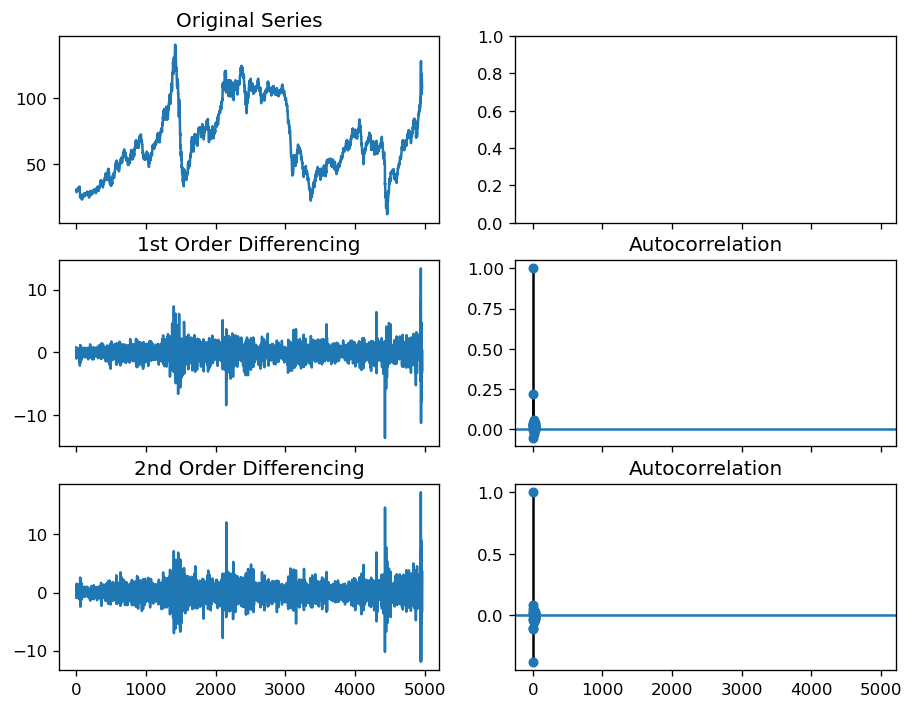

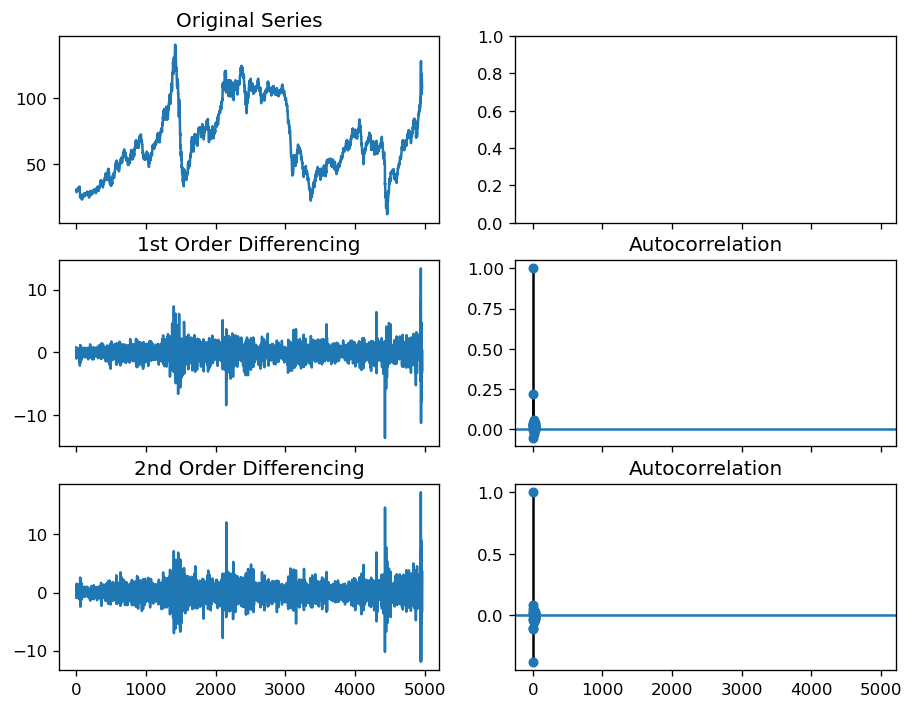

In [47]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Differencing
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(oil_df.Value); axes[0, 0].set_title('Original Series')
#plot_acf(oil_df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(oil_df.Value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(oil_df.Value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(oil_df.Value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(oil_df.Value.diff().diff().dropna(), ax=axes[2, 1])

The series reaches stationarity after two orders of differencing but we will take order of differencing as 1 since the second one goes in to negative

In [48]:
y = oil_df.Value

In [49]:
## Adf Test
ndiffs(y, test='adf')  # 2

1

In [50]:
# KPSS test
ndiffs(y, test='kpss')  # 1

1

In [51]:
# PP test
ndiffs(y, test='pp')  # 1

1

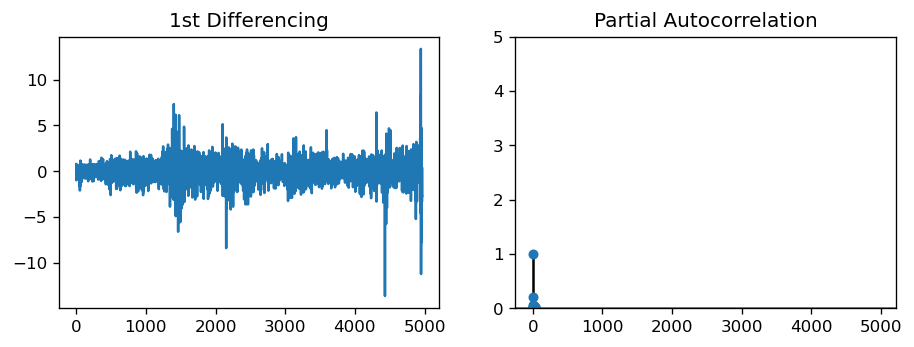

In [52]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(oil_df.Value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(oil_df.Value.diff().dropna(), ax=axes[1])

plt.show()

We will fix, or the AR term as p = 1

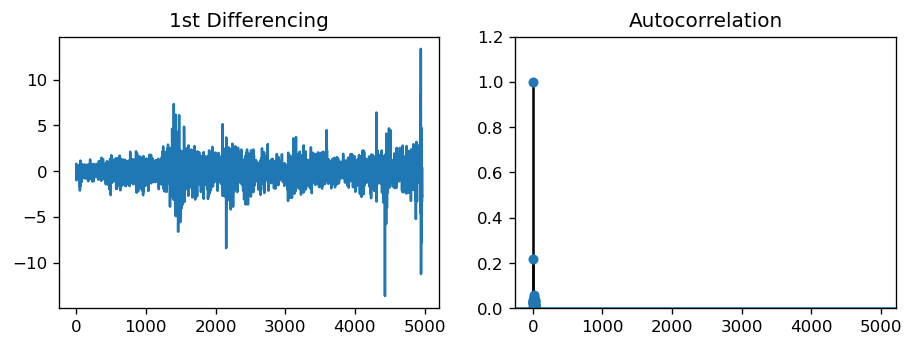

In [53]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(oil_df.Value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(oil_df.Value.diff().dropna(), ax=axes[1])

plt.show()

We will take the MA order to be q = 1 since only the first lagg exceeds the blue area

In [56]:
# 1,1,1 ARIMA

model = ARIMA(oil_df.Value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 4965
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7557.974
Method:                       css-mle   S.D. of innovations              1.109
Date:                Thu, 28 Apr 2022   AIC                          15123.949
Time:                        15:19:13   BIC                          15149.989
Sample:                             1   HQIC                         15133.079
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0155      0.020      0.789      0.430      -0.023       0.054
ar.L1.D.Value     0.1204      0.063      1.902      0.057      -0.004       0.244
ma.L1.D.Value     0.1008      0.063     

In [57]:
# 1,1,2 ARIMA

model = ARIMA(oil_df.Value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 4965
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -7557.831
Method:                       css-mle   S.D. of innovations              1.109
Date:                Thu, 28 Apr 2022   AIC                          15125.661
Time:                        15:19:19   BIC                          15158.212
Sample:                             1   HQIC                         15137.074
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0156      0.020      0.794      0.427      -0.023       0.054
ar.L1.D.Value    -0.1606      0.303     -0.531      0.596      -0.754       0.433
ma.L1.D.Value     0.3820      0.302     

The second ARIMA model we created is far better since the MA1 and AR1 P>|z| values are signifficant, i.e., less than 0.05

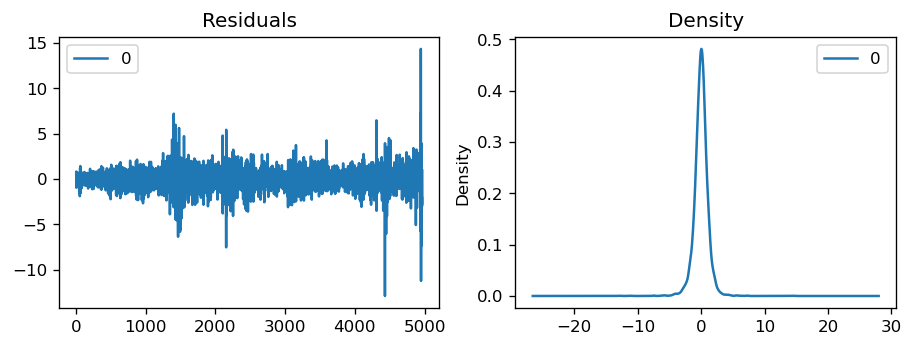

In [58]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

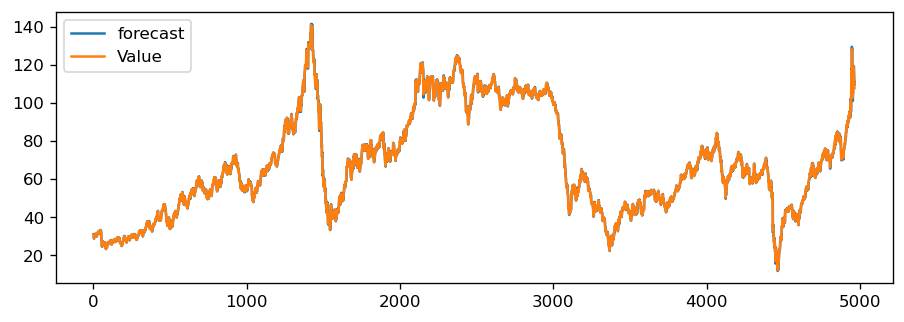

In [61]:
model_fit.plot_predict(dynamic=False)
plt.show()

# Out-of-Time Cross Validation

In [73]:
# Create Training and Test
train = oil_df.Value[:4800]
test = oil_df.Value[4800:]

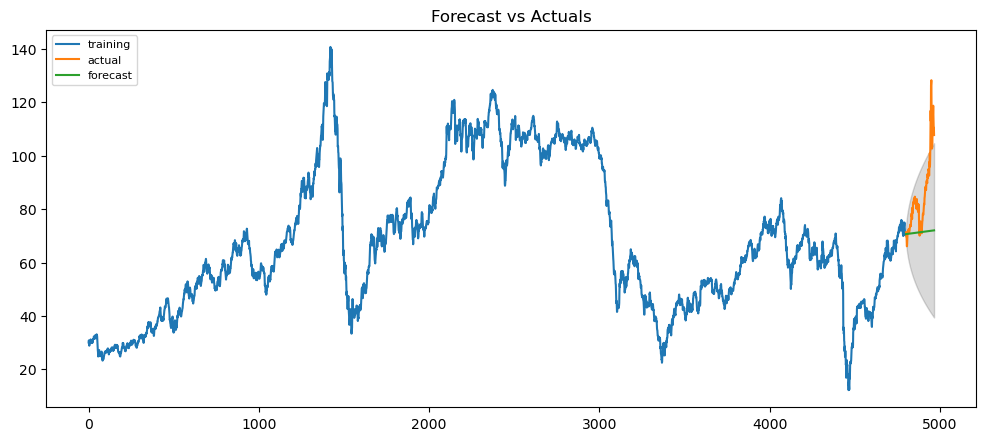

In [78]:
# Build Model
 
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(166, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()